In [11]:
import sys
del sys.modules["helpers2"]

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from GGA import GGA
from ocat import OCAT
from test import CAModel,Testing1
import helpers
import helpers2
import ganuggets2
from joblib import Parallel, delayed,parallel_backend

# Preprocessing

In [2]:
if not os.path.isfile("data/data.npy"):
    dirName = "data/images"
    images = []
    paths = []
    for file in os.listdir(dirName):
        if (".png" in file):
            paths.append([int(file.split("_")[1].replace(".png","")),f'{dirName}/{file}'])
    paths = sorted(paths,key=lambda x:x[0])
    for path in paths:
        img = cv2.imread(path[1],cv2.IMREAD_GRAYSCALE)
        images.append(img)
    images=np.array(images)
    values = {}
    count = 0
    for state in images:
        for row in state:
            for j,col in enumerate(row):
                if col not in values:
                    count+=1
                    values[col] = count
                row[j] = values[col]
    np.save("data/data.npy",images)
else:
    print("data.npy already exist")

data.npy already exist


In [3]:
def getProblemSub2(data,iState,cell,stateSize,currentState,neighborhood,paddingType,paddingValue):
    index = tuple([iState]+cell)
    cls = data[index]
    #start = time.time()
    neighbors = helpers.getNeighbors(cell,neighborhood,stateSize)
    #print("neighbors time {}".format(time.time()-start))
    values = helpers.getNeighborsValue(currentState,neighbors,paddingType,paddingValue)
    #print("neighbors value time {}".format(time.time()-start))
    if values != None:
        values = [values[key] for key in values]
        values.append(cls)
    #print("neighbors value 2 time {}".format(time.time()-start))
    return values
    
def getProblemSub1(data,iState,dataSize,stateSize,noStates,neighborhood,paddingType,paddingValue):
    print(iState)
    currentState = data[iState-1].reshape(-1)
    backend = 'threading'
    with parallel_backend(backend):
        vlscls = Parallel(n_jobs=4)(delayed(getProblemSub2) (data,iState,cell,stateSize,currentState,neighborhood,paddingType,paddingValue) for cell in helpers.multiDimensionalGenerator(stateSize))
        vlscls = list(filter(lambda x: x != None,vlscls))
    return vlscls

def getProblem(data,neighborhood,paddingType,paddingValue):
    problem = []
    dataSize = np.shape(data)
    stateSize = dataSize[1:]
    noStates = dataSize[0]
    backend = 'threading'
    with parallel_backend(backend):
        problem = Parallel(n_jobs=4)(delayed(getProblemSub1)(data,iState,dataSize,stateSize,noStates,neighborhood,paddingType,paddingValue) for iState in range(1,noStates))
        problem = np.concatenate(problem)
    return problem

In [4]:
data= np.load("data/data.npy")

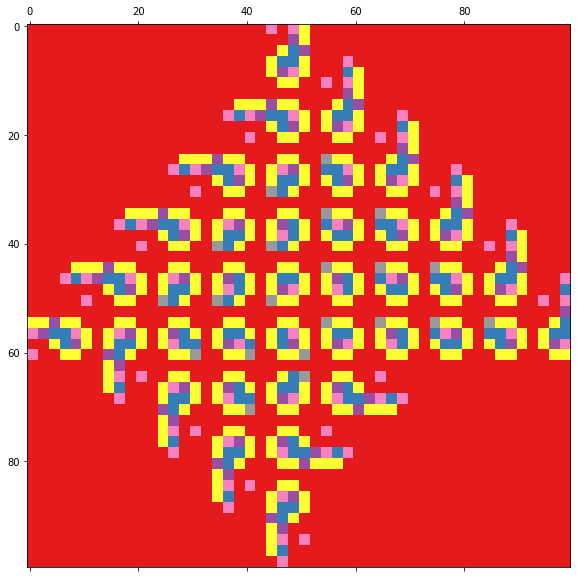

In [12]:
dirName = "data/images"
images = []
paths = []
for file in os.listdir(dirName):
    if (".png" in file):
        paths.append([int(file.split("_")[1].replace(".png","")),f'{dirName}/{file}'])
paths = sorted(paths,key=lambda x:x[0])
for path in paths:
    img = cv2.imread(path[1],cv2.IMREAD_GRAYSCALE)
    images.append(img)
images=np.array(images)
vid = helpers.animate(images[:160,150:250,270:370])
vid.save("byl.mp4")

In [5]:
np.shape(data)

(300, 400, 640)

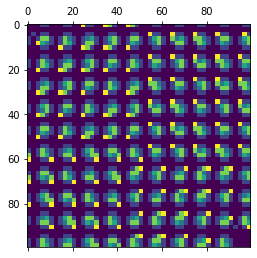

In [6]:
plt.matshow(data[-1,150:250,270:370])

In [8]:
radious = 1
neighborhood = helpers.moore([radious,radious])
data = getProblem(data[:160,150:250,270:370],neighborhood,2,-1)

12
3

4
56

7
8
910

11
12
13
14
1516

17
1819

20
21
2223
24

25
26
27
28
29
30
31
32
33
34
3536

37
38
39
40
41
42
43
44
45
46
47
48
49
50
5152

53
54
55
56
57
58
59
60
61
62
6364

65
66
67
68
69
70
71
72
73
74
7576

77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103104

105
106
107
108
109
110
111
112
113
114
115116

117
118
119
120
121
122
123124

125
126
127
128
129130

131
132
133134

135136

137
138
139140

141142

143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


In [36]:
modelGGA = GGA(data,np.shape(data)[1]-1,path="saves/Experiment1",verbose=0,noChilds=10,noChromosomes=100)

In [37]:
modelGGA.run()

config saved at saves/Experiment1/06_02_20_19_00_15/config.json
iteration 1
goal = 1
goal = 6goal = 2

goal = 5
goal 1 elapsed time: 1.178999423980713goal 6 elapsed time: 1.1840031147003174

goal = 3goal = 4
goal 5 elapsed time: 1.2260010242462158goal 2 elapsed time: 1.2609913349151611


goal 3 elapsed time: 0.6659998893737793
goal 4 elapsed time: 0.6790006160736084
iteration 2
goal = 1goal = 6
goal = 2
goal = 5

goal 1 elapsed time: 0.17699956893920898
goal = 3
goal 6 elapsed time: 0.1959986686706543
goal = 4goal 5 elapsed time: 0.2089996337890625goal 2 elapsed time: 0.22499990463256836


goal 3 elapsed time: 0.1250007152557373
goal 4 elapsed time: 0.12899994850158691
iteration 3
goal = 1goal = 6
goal = 2goal = 5


goal 6 elapsed time: 0.16500043869018555
goal = 3
goal 5 elapsed time: 0.18700218200683594goal 1 elapsed time: 0.21299982070922852

goal 2 elapsed time: 0.23000001907348633goal = 4

goal 3 elapsed time: 0.12300419807434082
goal 4 elapsed time: 0.09099864959716797
iteration 

In [38]:
caggamodel = CAModel(modelGGA.rules,neighborhood,1,-1)

In [39]:
modelOCAT = OCAT(data,np.shape(data)[1]-1)

problem
matrix
domain
binarized
bdomains
indexes
dindex
pos index
neg index
auxiliar
terms


In [40]:
modelOCAT.train()

training for value 1
1081
1075
1056
981
886
878
861
833
815
805
792
789
789
785
781
770
757
753
716
670
631
623
604
594
593
575
550
548
500
500
436
433
430
427
423
416
399
394
390
388
380
373
366
354
350
350
350
348
344
337
333
332
330
329
311
309
308
306
298
297
296
295
294
292
288
287
286
284
281
273
265
258
246
240
238
237
233
232
231
230
227
227
223
222
220
217
210
210
210
209
208
208
201
200
199
198
195
190
190
190
189
189
189
189
188
185
185
184
184
180
178
178
177
176
171
171
170
170
170
169
167
166
166
166
166
164
164
163
163
162
160
160
157
157
157
155
152
152
151
150
150
149
147
147
139
138
137
131
131
130
129
128
127
125
125
124
120
119
119
118
118
118
118
118
118
118
114
114
113
113
113
112
112
112
112
112
111
110
110
110
110
108
108
108
108
108
107
103
102
102
101
101
99
97
97
97
97
97
97
96
94
93
93
92
91
90
89
89
88
88
88
88
88
88
88
87
87
86
86
86
86
85
85
85
85
85
84
84
84
84
84
82
82
82
82
82
82
82
82
82
82
difficult element 100/1000 to delete it
82
82
82
82
82
82
82


[[1,
  [{(1, 1, '<'),
    (1, 4, '<'),
    (2, 3, '>='),
    (4, 2, '<'),
    (4, 4, '>='),
    (6, 1, '<'),
    (7, 6, '>='),
    (8, 2, '<'),
    (8, 3, '>=')},
   {(0, 6, '<'),
    (1, 1, '<'),
    (3, 3, '>='),
    (4, 2, '<'),
    (4, 6, '>='),
    (5, 1, '<'),
    (6, 1, '<')},
   {(4, 2, '<'), (4, 5, '>='), (5, 5, '<'), (6, 1, '<'), (7, 4, '>=')},
   {(1, 1, '<'), (3, 3, '<'), (4, 2, '<'), (4, 3, '>='), (6, 1, '<')},
   {(0, 4, '<'),
    (0, 5, '>='),
    (1, 1, '<'),
    (2, 4, '>='),
    (3, 1, '<'),
    (3, 5, '<'),
    (6, 1, '<'),
    (6, 6, '>=')},
   {(1, 6, '>='), (2, 6, '<'), (3, 3, '<'), (3, 6, '>=')},
   {(1, 1, '<'), (4, 2, '<'), (5, 1, '>='), (6, 1, '<'), (7, 6, '>=')},
   {(0, 5, '>='),
    (2, 1, '<'),
    (3, 1, '<'),
    (3, 2, '<'),
    (4, 2, '<'),
    (4, 3, '>='),
    (7, 6, '>='),
    (8, 1, '<'),
    (8, 4, '<'),
    (8, 5, '>=')},
   {(1, 1, '<'),
    (2, 4, '<'),
    (3, 1, '<'),
    (4, 4, '<'),
    (4, 5, '>='),
    (5, 4, '>='),
    (7, 6, '>='),
    

In [5]:
radious = 1
neighborhood = ganuggets2.moore([radious,radious])
paddingType = 2
paddingValue = 0
beta = 2
w1 = 1
w2 = 5
antMaxSize = 50
antMinSize = 3
population = 100
mutationRate = .05
crossprob = .5
noOffsprings = 2
noSteps = 100
print("step 1")
problem = ganuggets2.getLearningProblem(data[:160,150:250,270:370],neighborhood,paddingType,paddingValue)
print("step 2")
matrix = ganuggets2.dictToMat(problem)
print("step 3")
domain = ganuggets2.getDomain(matrix)
print("step 4")
binarized = np.array(ganuggets2.binarize(matrix,domain))
print("step 5")
binDomain = ganuggets2.getDomain(binarized)
print("step 6")

step 1
step 2
step 3
step 4
step 5
step 6


In [6]:
goalAttr = list(binDomain.keys())[-1]
noEvents = ganuggets2.calculateNoEvents([goalAttr],binDomain,binarized)
print("step 7")
fit,pop,fitnessHistory = ganuggets2.ganuggets(population,noOffsprings,antMinSize,antMaxSize,beta,w1,w2,mutationRate,crossprob,binarized,binDomain,goalAttr,noEvents,-1,noSteps)
print("step 8")
bestInd = {}
for f in fit:
    if f[2] not in bestInd:
        bestInd[f[2]] = f
    if f[1] > bestInd[f[2]][1]:
        bestInd[f[2]] = f
bestPop = []
for key in bestInd:
    bestPop.append(pop[bestInd[key][0]])
print("step 9")
rules = ganuggets2.populationPostprocessing(bestPop)
print("step 10")
dRules = ganuggets2.binarizedToDomain(rules,domain)
print(bestInd)
dRules

step 7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
step 8
step 9
step 10
{2: [0, 0.9584945752764549, 2], 5: [101, 0.9062680393499933, 5], 1: [202, 0.9058176162641333, 1], 4: [303, 0.8890407290261223, 4], 3: [404, 0.8541571731467394, 3], 6: [505, 0.5783587144781226, 6]}


{2: '(A[0] < 6) and (A[1] >= 2) and (A[1] >= 4) and (A[2] >= 3) and (A[2] < 6) and (A[3] >= 1) and (A[3] >= 2) and (A[4] >= 1) and (A[4] < 3) and (A[5] >= 1) and (A[6] < 4) and (A[7] >= 1) and (A[8] >= 3)',
 5: '(A[0] >= 1) and (A[0] < 4) and (A[1] >= 3) and (A[3] >= 1) and (A[3] >= 4) and (A[4] >= 1) and (A[4] < 5) and (A[5] >= 1) and (A[5] >= 4) and (A[5] < 5) and (A[7] >= 1) and (A[8] >= 2) and (A[8] < 6)',
 1: '(A[0] < 4) and (A[1] < 2) and (A[2] >= 3) and (A[2] < 5) and (A[3] < 2) and (A[4] >= 1) and (A[6] >= 2) and (A[8] >= 5)',
 4: '(A[0] >= 1) and (A[1] >= 1) and (A[1] >= 3) and (A[1] < 4) and (A[4] < 4) and (A[4] < 5) and (A[5] >= 4) and (A[5] < 5) and (A[7] >= 3) and (A[8] >= 1) and (A[8] >= 2)',
 3: '(A[0] >= 1) and (A[1] >= 2) and (A[1] >= 3) and (A[1] < 4) and (A[2] >= 4) and (A[4] >= 1) and (A[4] < 6) and (A[5] >= 3) and (A[5] >= 4) and (A[5] >= 5) and (A[6] >= 2) and (A[7] >= 1) and (A[8] >= 1) and (A[8] >= 2) and (A[8] >= 4) and (A[8] >= 5) and (A[8] < 6)',
 6: '(A[0] >

In [7]:
funs = {}
for key in dRules:
    temp = "lambda A:"+dRules[key]
    funs[key] = eval(temp)
caganuggetsmodel = CAModel(funs,neighborhood,1,-1)

In [42]:
id = 300
count = {}
other = {}
for id in range(len(data)):
    for op in modelOCAT.rules2:
        if modelOCAT.rules2[op](data[id,:-1]) and op == data[id,-1]:
            if op not in count:
                count[op] = 0
            count[op] +=1
            break
        if modelOCAT.rules2[op](data[id,:-1]) and  op != data[id,-1]:
            if op not in other:
                other[op] = 0
            other[op] +=1
            break
count,other

({1: 1462052, 6: 2141, 2: 60975, 5: 21471, 3: 9558, 4: 12968},
 {5: 9421, 1: 4166, 3: 3582, 6: 357, 2: 2705, 4: 604})

In [43]:
caocatmodel = CAModel(modelOCAT.rules2,neighborhood,1,-1)

In [9]:
data= np.load("data/data.npy")
data = data[:200,150:250,270:370]
data=np.array(data)

Testing:
state 1/200
state 2/200
state 3/200
state 4/200
state 5/200
state 6/200
state 7/200
state 8/200
state 9/200
state 10/200
state 11/200
state 12/200
state 13/200
state 14/200
state 15/200
state 16/200
state 17/200
state 18/200
state 19/200
state 20/200
state 21/200
state 22/200
state 23/200
state 24/200
state 25/200
state 26/200
state 27/200
state 28/200
state 29/200
state 30/200
state 31/200
state 32/200
state 33/200
state 34/200
state 35/200
state 36/200
state 37/200
state 38/200
state 39/200
state 40/200
state 41/200
state 42/200
state 43/200
state 44/200
state 45/200
state 46/200
state 47/200
state 48/200
state 49/200
state 50/200
state 51/200
state 52/200
state 53/200
state 54/200
state 55/200
state 56/200
state 57/200
state 58/200
state 59/200
state 60/200
state 61/200
state 62/200
state 63/200
state 64/200
state 65/200
state 66/200
state 67/200
state 68/200
state 69/200
state 70/200
state 71/200
state 72/200
state 73/200
state 74/200
state 75/200
state 76/200
state 77/200

<module 'matplotlib.pyplot' from 'C:\\Users\\hecto\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

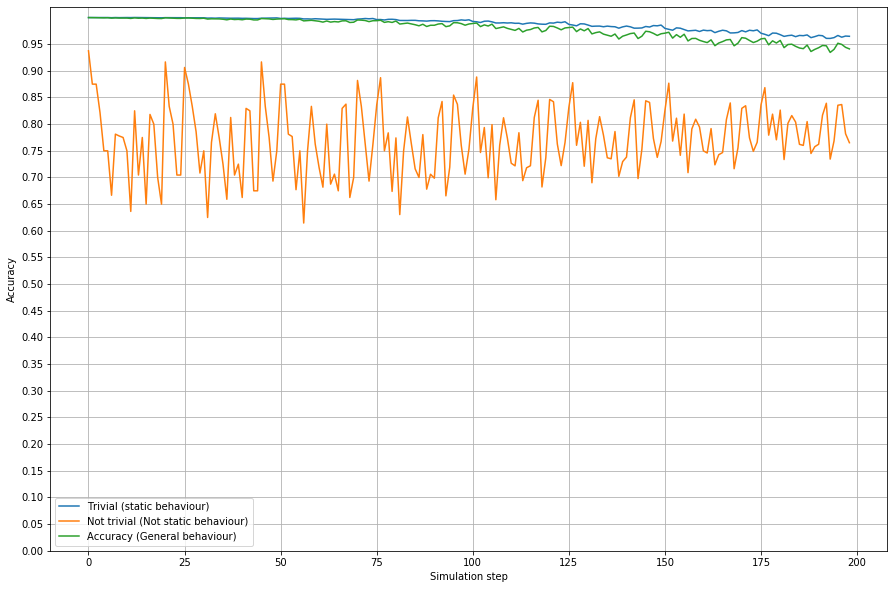

In [48]:
test1 = Testing1(data,caocatmodel,verbose=1)
test1.run()
test1.plot()

Testing:
state 1/200
state 2/200
state 3/200
state 4/200
state 5/200
state 6/200
state 7/200
state 8/200
state 9/200
state 10/200
state 11/200
state 12/200
state 13/200
state 14/200
state 15/200
state 16/200
state 17/200
state 18/200
state 19/200
state 20/200
state 21/200
state 22/200
state 23/200
state 24/200
state 25/200
state 26/200
state 27/200
state 28/200
state 29/200
state 30/200
state 31/200
state 32/200
state 33/200
state 34/200
state 35/200
state 36/200
state 37/200
state 38/200
state 39/200
state 40/200
state 41/200
state 42/200
state 43/200
state 44/200
state 45/200
state 46/200
state 47/200
state 48/200
state 49/200
state 50/200
state 51/200
state 52/200
state 53/200
state 54/200
state 55/200
state 56/200
state 57/200
state 58/200
state 59/200
state 60/200
state 61/200
state 62/200
state 63/200
state 64/200
state 65/200
state 66/200
state 67/200
state 68/200
state 69/200
state 70/200
state 71/200
state 72/200
state 73/200
state 74/200
state 75/200
state 76/200
state 77/200

<module 'matplotlib.pyplot' from 'C:\\Users\\hecto\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

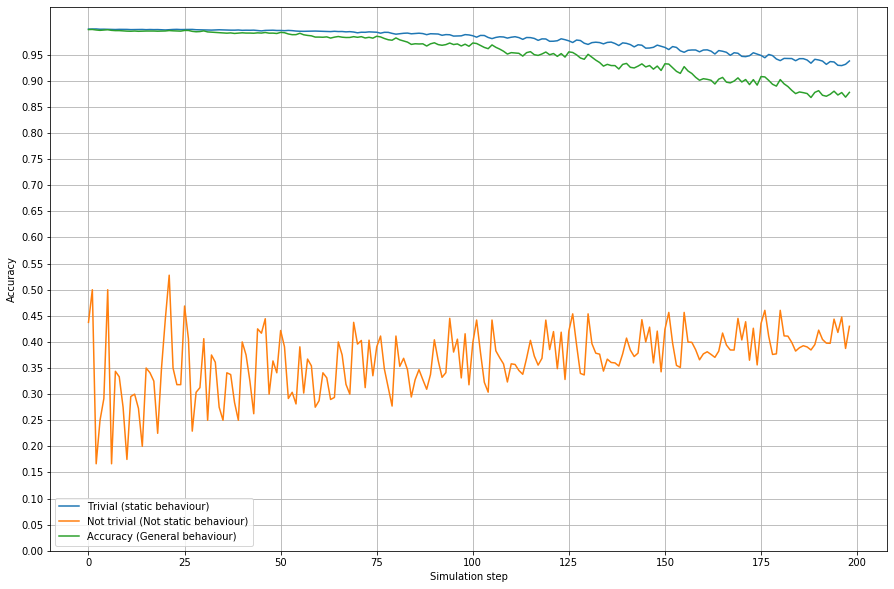

In [49]:
test2 = Testing1(data,caggamodel,verbose=1)
test2.run()
test2.plot()

Testing:
state 1/200
Static : 9984/9984
Dynamic : 0/16
Accuracy: 9984 / 10000
state 2/200
Static : 9984/9984
Dynamic : 0/16
Accuracy: 9984 / 10000
state 3/200
Static : 9976/9976
Dynamic : 0/24
Accuracy: 9976 / 10000
state 4/200
Static : 9972/9972
Dynamic : 0/28
Accuracy: 9972 / 10000
state 5/200
Static : 9976/9976
Dynamic : 0/24
Accuracy: 9976 / 10000
state 6/200
Static : 9984/9984
Dynamic : 0/16
Accuracy: 9984 / 10000
state 7/200
Static : 9976/9976
Dynamic : 0/24
Accuracy: 9976 / 10000
state 8/200
Static : 9968/9968
Dynamic : 0/32
Accuracy: 9968 / 10000
state 9/200
Static : 9964/9964
Dynamic : 0/36
Accuracy: 9964 / 10000
state 10/200
Static : 9960/9960
Dynamic : 0/40
Accuracy: 9960 / 10000
state 11/200
Static : 9960/9960
Dynamic : 0/40
Accuracy: 9960 / 10000
state 12/200
Static : 9956/9956
Dynamic : 0/44
Accuracy: 9956 / 10000
state 13/200
Static : 9960/9960
Dynamic : 0/40
Accuracy: 9960 / 10000
state 14/200
Static : 9956/9956
Dynamic : 0/44
Accuracy: 9956 / 10000
state 15/200
Static 

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

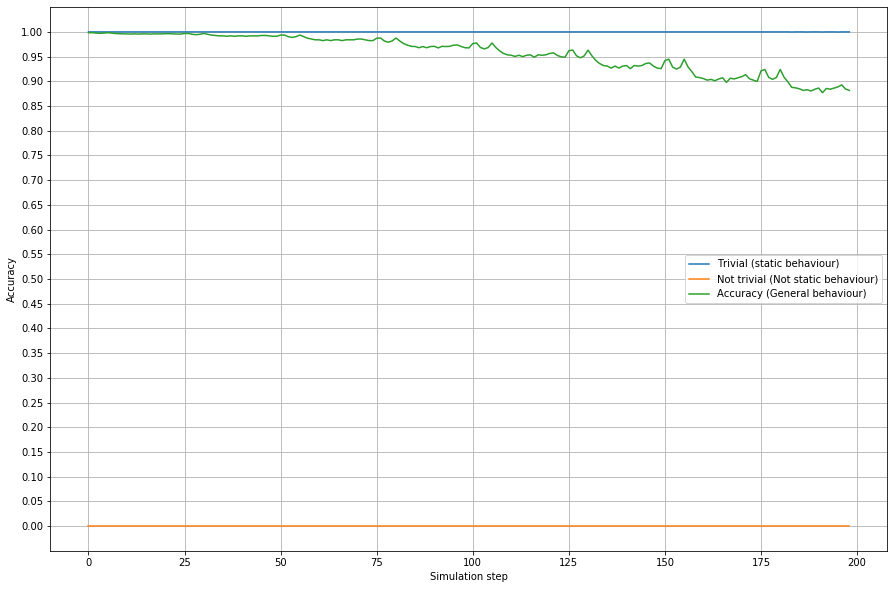

In [10]:
test3 = Testing1(data,caganuggetsmodel,verbose=2)
test3.run()
test3.plot()

<module 'matplotlib.pyplot' from 'C:\\Users\\hecto\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

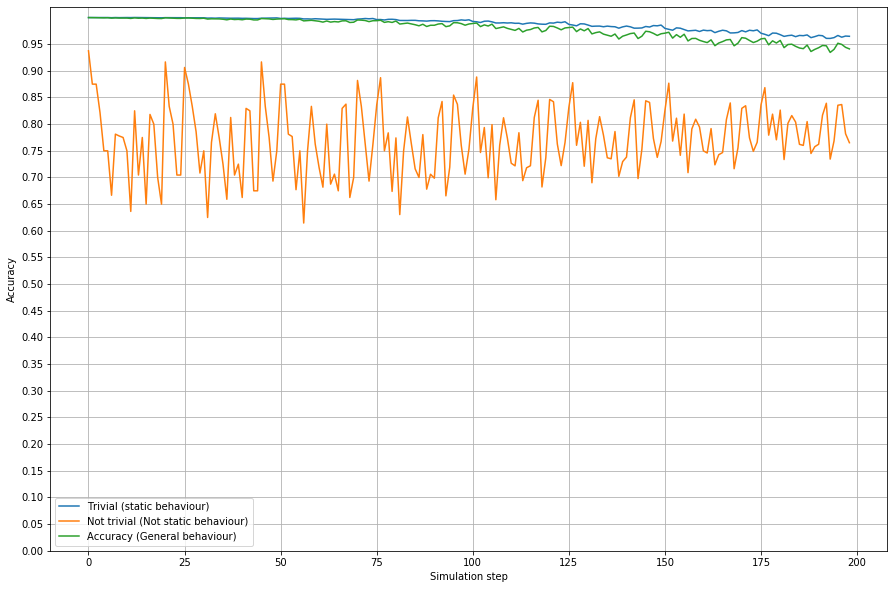

In [51]:
test1.plot()

<module 'matplotlib.pyplot' from 'C:\\Users\\hecto\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

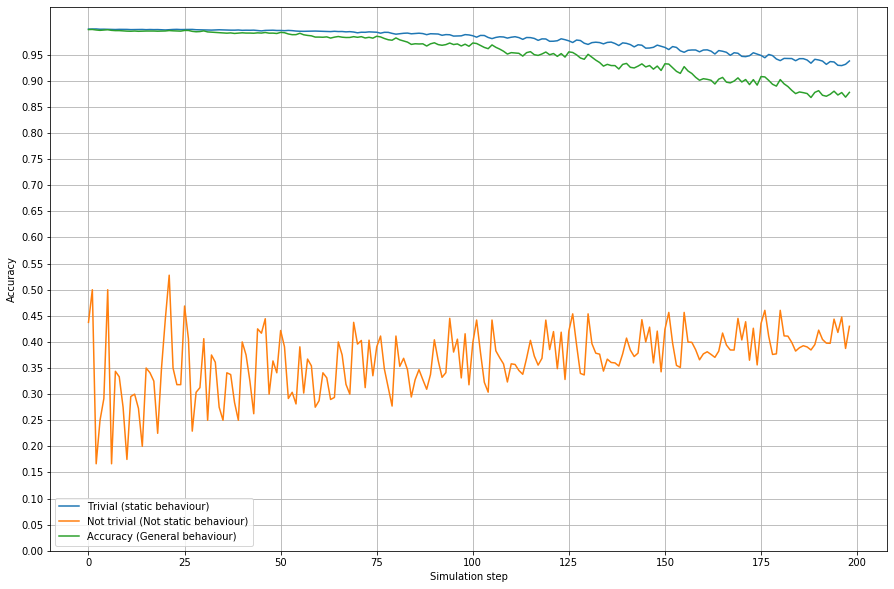

In [52]:
test2.plot()

<module 'matplotlib.pyplot' from '/Users/hectormoreno/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

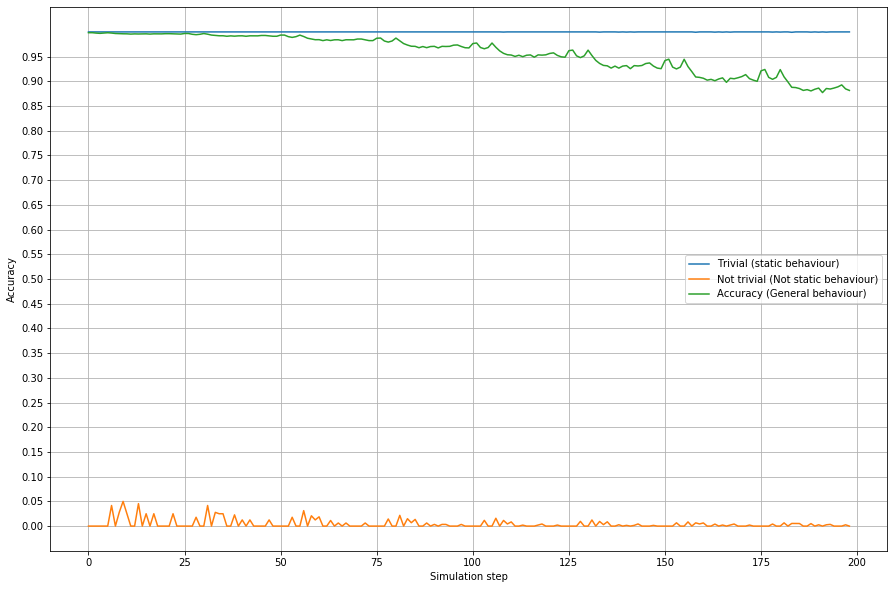

In [27]:
test3.plot()

In [53]:
results_path = f"{modelGGA.path}/{modelGGA.date}"
np.savetxt(f"{results_path}/ocat.csv",test1.result,delimiter=",",header="trivial,nontrivial,accuracy")
np.savetxt(f"{results_path}/gga.csv",test2.result,delimiter=",",header="trivial,nontrivial,accuracy")

In [11]:
np.savetxt(f"nuggets.csv",test3.result,delimiter=",",header="trivial,nontrivial,accuracy")

In [13]:
res,mn,mx,rows,conflict = helpers2.getBinaryStrings(data,data.shape[1]-1)

getting domains
get row number function
lambda x0,x1,x2,x3,x4,x5,x6,x7,x8:1679616*x0+279936*x1+46656*x2+7776*x3+1296*x4+216*x5+36*x6+6*x7+1*x8
lambda domain,x:[domain[0][x[0]],domain[1][x[1]],domain[2][x[2]],domain[3][x[3]],domain[4][x[4]],domain[5][x[5]],domain[6][x[6]],domain[7][x[7]],domain[8][x[8]]]
building binary strings
10030651 0
string for key1
string for key6
string for key2
string for key5
string for key3
string for key4


In [14]:
from pybdm import BDM 
bdm = BDM(ndim=1)
for k in res:
    val = bdm.bdm(res[k], normalized=True)
    print(k,val)

total 0.014260275045823579
1 0.006865439208978472
6 0.0031612270175042346
2 0.007031249974924521
5 0.0064840785454382795
3 0.004842048280284584
4 0.00451157492617127


In [16]:
import math
noMinVars = math.ceil(math.log2(mx))
noMinVars

24